# Imports

In [5]:
!pip install efficientnet

In [36]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from os import listdir
from os.path import join, isfile
#preprocessin
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#model and layers
import efficientnet.tfkeras as efn
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense,Conv2D,MaxPool2D, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#metrics
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.metrics import AUC, CategoricalAccuracy, Precision, Recall
import tensorflow as tf

In [37]:
IMAGE_SIZE = 224
BATCH_SIZE = 64
epochs = 30

In [38]:
files = listdir('/kaggle/input/arabicletterdataset/data/data/images/train_with_lablels')
files

['7',
 '17',
 '19',
 '22',
 '2',
 '23',
 '10',
 '5',
 '20',
 '27',
 '25',
 '8',
 '12',
 '18',
 '28',
 '16',
 '13',
 '26',
 '15',
 '3',
 '1',
 '14',
 '4',
 '9',
 '21',
 '6',
 '11',
 '24']

In [39]:
label =files
NUM_CLASS=len(label)

In [40]:
train_gen = ImageDataGenerator(
    #rotation_range=15,
    rescale=1./255,
    zoom_range=0.2,
    #horizontal_flip=True,
    #fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1,
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
#     preprocessing_function = efn.preprocess_input
)

# Only rescaling the val set
val_gen = ImageDataGenerator(
    rescale=1/255.0,
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
#     preprocessing_function = efn.preprocess_input
)

In [41]:
train_generator = train_gen.flow_from_directory(
    directory="/kaggle/input/arabicletterdataset/data/data/images/train_with_lablels",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 13440 images belonging to 28 classes.


In [42]:
valid_generator = val_gen.flow_from_directory(
    directory='/kaggle/input/arabicletterdataset/data/data/images/test_with_labels',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
)

Found 3360 images belonging to 28 classes.


In [43]:
class_dict= {v:k for k,v in train_generator.class_indices.items()}
class_dict

{0: '1',
 1: '10',
 2: '11',
 3: '12',
 4: '13',
 5: '14',
 6: '15',
 7: '16',
 8: '17',
 9: '18',
 10: '19',
 11: '2',
 12: '20',
 13: '21',
 14: '22',
 15: '23',
 16: '24',
 17: '25',
 18: '26',
 19: '27',
 20: '28',
 21: '3',
 22: '4',
 23: '5',
 24: '6',
 25: '7',
 26: '8',
 27: '9'}

In [14]:
def see_examples(datagen, figsize=(16,16),nrows=4, ncols=4):
    fig, ax = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols)
    batch_idx = np.random.randint(low=0, high=len(datagen), size=(nrows,ncols))
    for i in range(nrows):
        for j in range(ncols):
            imgs, labels = datagen[batch_idx[i,j]]
            sample_idx = np.random.randint(low=0, high=len(imgs))
            img = imgs[sample_idx]
            label = labels[sample_idx]
            label = class_dict[np.argmax(label)]
            ax[i,j].axis('off')
            ax[i,j].imshow(img)
            ax[i,j].set_title(label)
    plt.show()

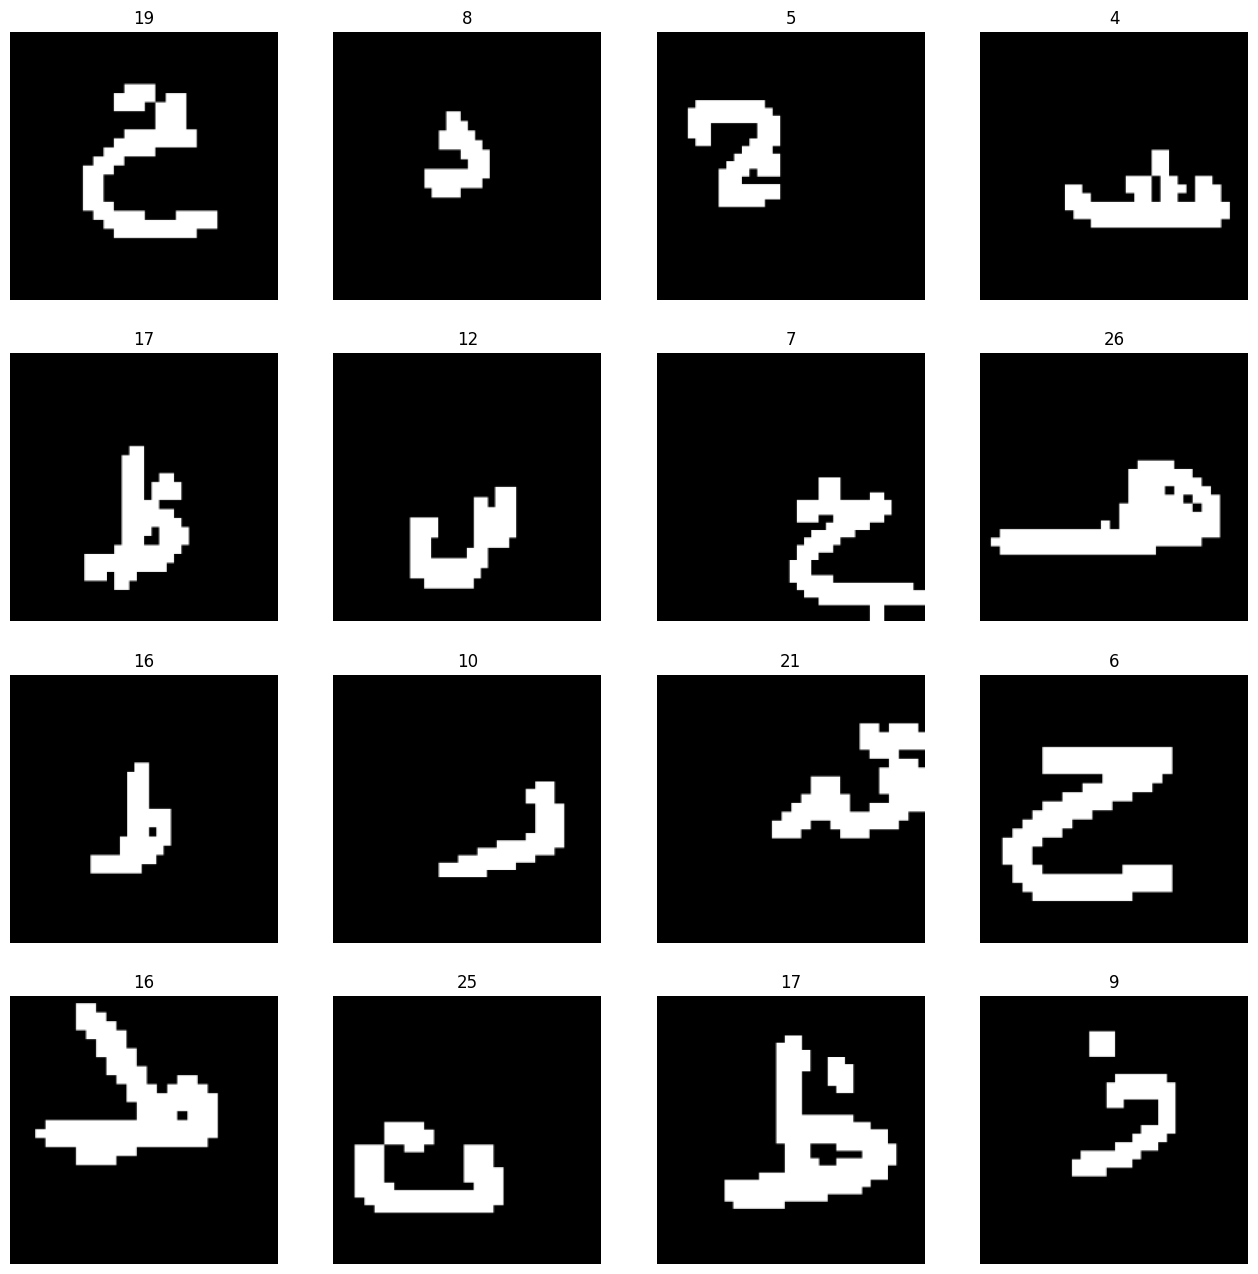

In [15]:
see_examples(train_generator)

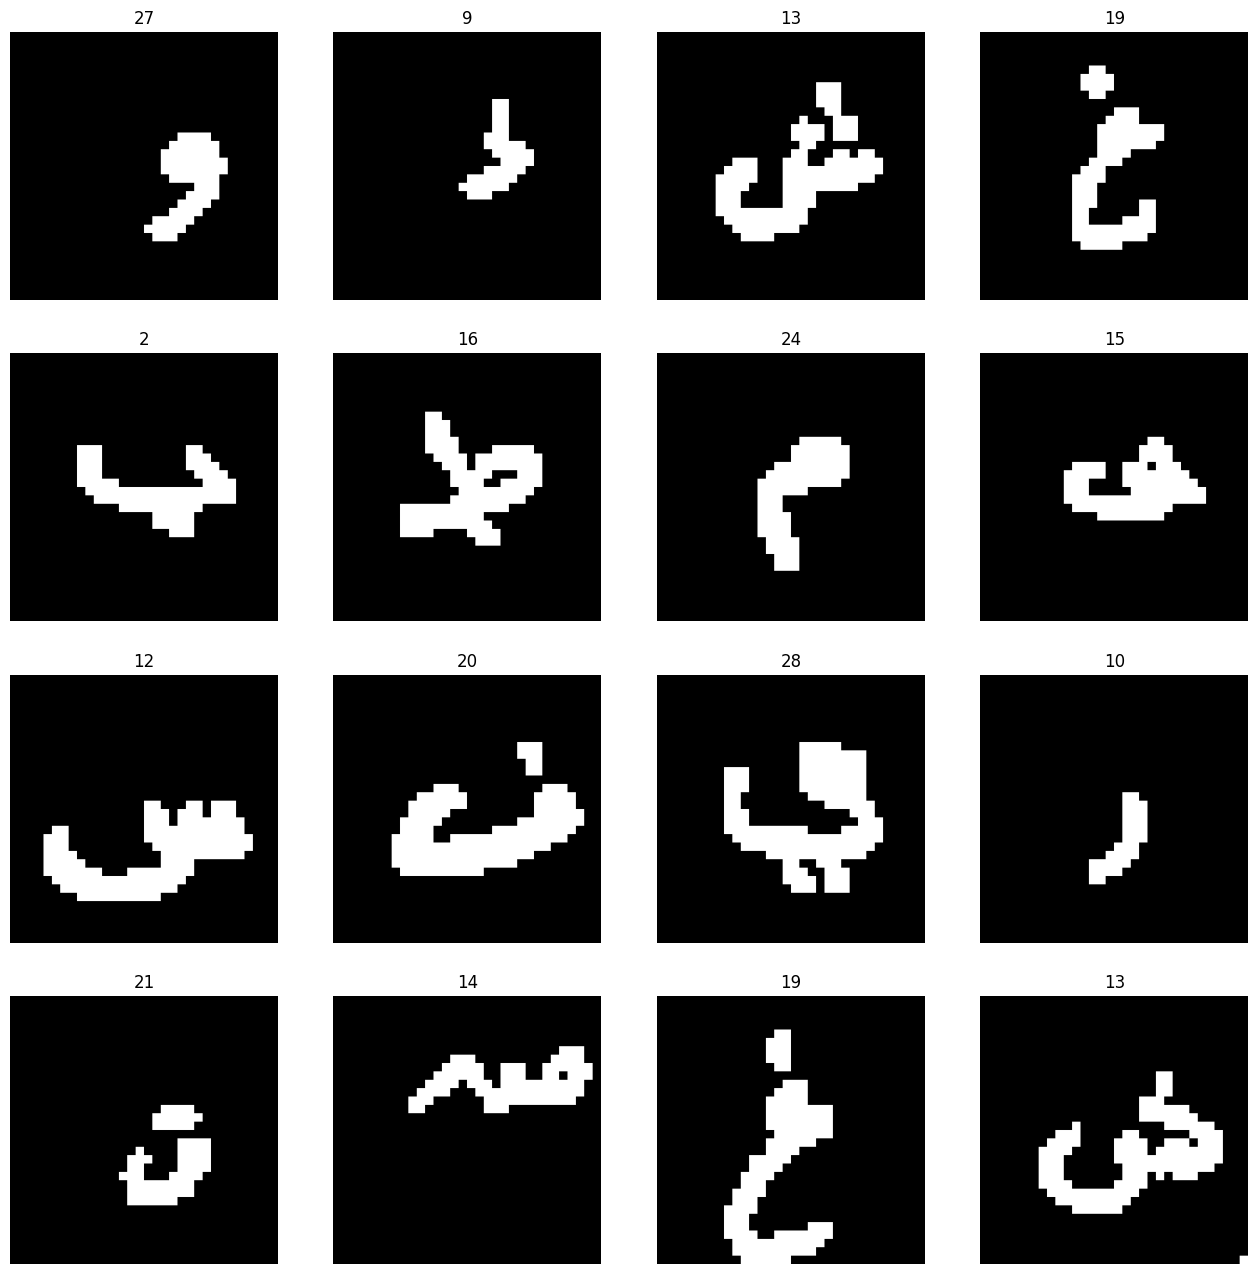

In [16]:
see_examples(valid_generator)

In [61]:
conv_base = efn.EfficientNetB0(weights='imagenet',
                  include_top=False,
                  input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3))


In [62]:
# conv_base = VGG16(weights='imagenet',
#                   include_top=False,
#                   input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3))
# conv_base.trainable=True 

In [63]:
# conv_base.trainable = True

# set_trainable = False
# for layer in conv_base.layers:
#     if layer.name == 'block6a_expand_conv':
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False 

In [64]:
model = Sequential([
    conv_base,
    GlobalAveragePooling2D(),
    
    Dense(units=512,activation='relu'),
    Dropout(0.2),
    Dense(units=64, activation='relu'),
    Dropout(0.2),
    Dense(units=32, activation='relu'),
    Dense(units=NUM_CLASS, activation='softmax')
])

In [65]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 7, 7, 1280)       4049564   
 )                                                               
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_16 (Dense)            (None, 512)               655872    
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_17 (Dense)            (None, 64)                32832     
                                                                 
 dropout_9 (Dropout)         (None, 64)               

In [66]:
callbacks = [
    EarlyStopping(min_delta=1e-5, patience=8),
    ModelCheckpoint('best_model.h5', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_lr=0.001)
]

metrics = [
    CategoricalAccuracy(), 
    F1Score(num_classes=NUM_CLASS), 
    Precision(), 
    Recall(), 
#     AUC()
]

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [67]:
history = model.fit(train_generator,epochs=epochs, batch_size=BATCH_SIZE,
                  validation_data=valid_generator,callbacks= callbacks,
                            )

Epoch 1/30


2023-05-04 03:49:37.683657: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/efficientnet-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


210/210 [==============================] - 253s 1s/step - loss: 1.1618 - categorical_accuracy: 0.6584 - f1_score: 0.6627 - precision_4: 0.8538 - recall_4: 0.5649 - val_loss: 1.0937 - val_categorical_accuracy: 0.7807 - val_f1_score: 0.7831 - val_precision_4: 0.8018 - val_recall_4: 0.7619 - lr: 0.0010
Epoch 2/30
210/210 [==============================] - 212s 1s/step - loss: 0.3865 - categorical_accuracy: 0.8962 - f1_score: 0.8963 - precision_4: 0.9208 - recall_4: 0.8698 - val_loss: 0.2736 - val_categorical_accuracy: 0.9232 - val_f1_score: 0.9227 - val_precision_4: 0.9364 - val_recall_4: 0.9110 - lr: 0.0010
Epoch 3/30
210/210 [==============================] - 212s 1s/step - loss: 0.2770 - categorical_accuracy: 0.9251 - f1_score: 0.9252 - precision_4: 0.9396 - recall_4: 0.9098 - val_loss: 0.2672 - val_categorical_accuracy: 0.9244 - val_f1_score: 0.9247 - val_precision_4: 0.9350 - val_recall_4: 0.9167 - lr: 0.0010
Epoch 4/30
210/210 [==============================] - 214s 1s/step - loss: 

In [68]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,categorical_accuracy,f1_score,precision_4,recall_4,val_loss,val_categorical_accuracy,val_f1_score,val_precision_4,val_recall_4,lr
0,1.161836,0.658408,"[0.8536854, 0.69479877, 0.64901966, 0.5839537,...",0.853801,0.564881,1.093736,0.780655,"[0.88888896, 0.86580086, 0.61585367, 0.8089887...",0.801754,0.761905,0.001
1,0.386516,0.896205,"[0.95933264, 0.8685832, 0.8666667, 0.90778685,...",0.920835,0.869792,0.273629,0.923214,"[0.9830508, 0.8976378, 0.86307055, 0.9133858, ...",0.936372,0.911012,0.001
2,0.277007,0.925149,"[0.9780105, 0.8970438, 0.88352567, 0.9414226, ...",0.939604,0.909821,0.267202,0.924405,"[0.9917355, 0.9008265, 0.88392854, 0.9098039, ...",0.935033,0.916667,0.001
3,0.240883,0.936086,"[0.9770355, 0.9024896, 0.89123553, 0.9503106, ...",0.948608,0.922917,0.251732,0.928571,"[0.9874477, 0.88721806, 0.8482144, 0.9487179, ...",0.937632,0.921726,0.001
4,0.225529,0.938914,"[0.97810215, 0.9183674, 0.9015873, 0.9428868, ...",0.949966,0.926711,0.360536,0.916667,"[0.99159664, 0.87058824, 0.83253586, 0.9508197...",0.923517,0.912798,0.001


In [69]:
history_df['f1_score'] = history_df['f1_score'].apply(np.mean)
history_df['val_f1_score'] = history_df['val_f1_score'].apply(np.mean)

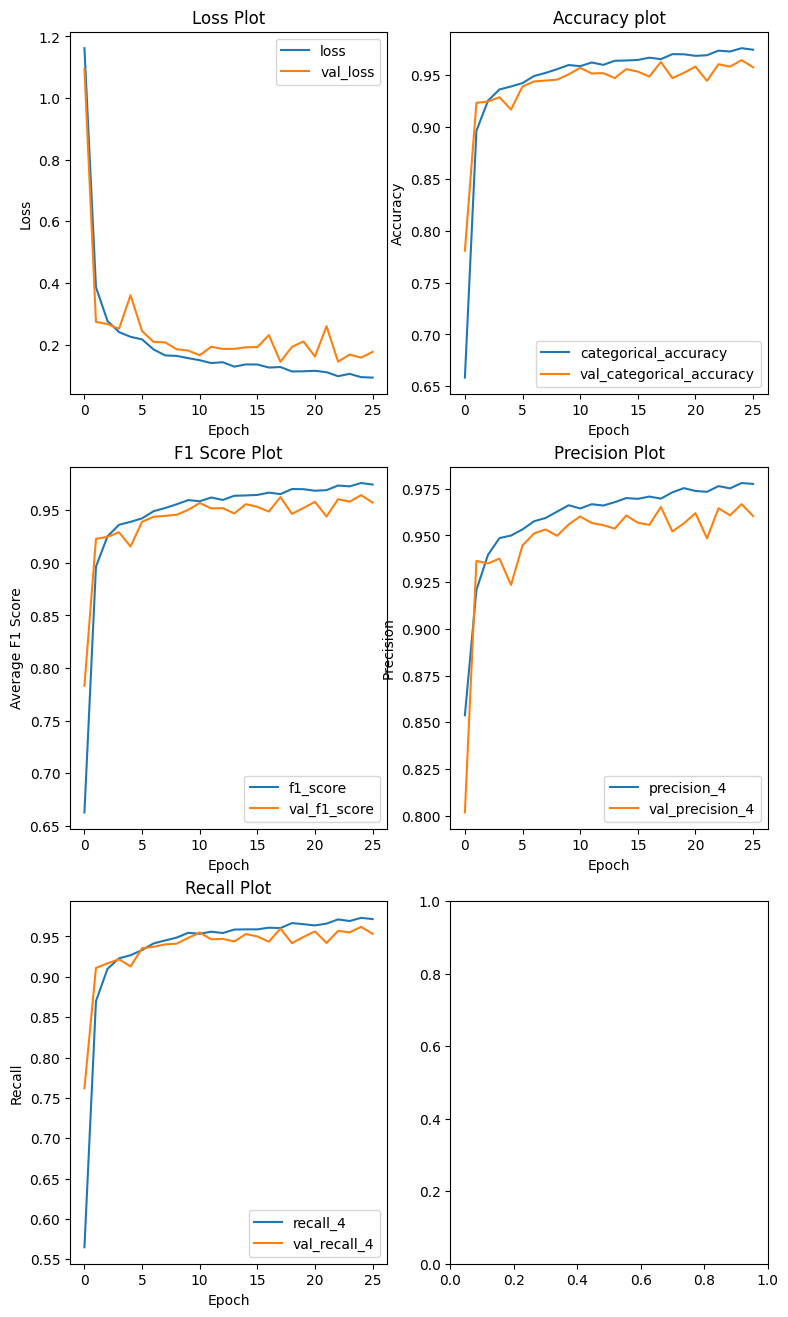

In [70]:
fig, ax = plt.subplots(figsize=(9,16), nrows=3,ncols=2)
history_df[['loss','val_loss']].plot(ax=ax[0,0], xlabel='Epoch',ylabel='Loss', title='Loss Plot')
history_df[['categorical_accuracy','val_categorical_accuracy']].plot(
    ax=ax[0,1], xlabel='Epoch',ylabel='Accuracy',title='Accuracy plot')
history_df[['f1_score','val_f1_score']].plot(ax=ax[1,0],xlabel='Epoch',ylabel='Average F1 Score',title='F1 Score Plot')
history_df[['precision_4','val_precision_4']].plot(ax=ax[1,1],xlabel='Epoch',ylabel='Precision',title='Precision Plot')
history_df[['recall_4','val_recall_4']].plot(ax=ax[2,0],xlabel='Epoch',ylabel='Recall',title='Recall Plot')
plt.show()

In [73]:
best_model = load_model('best_model.h5')

In [74]:
val_loss,val_acc, val_f1, val_precision, val_recall = best_model.evaluate(valid_generator)

53/53 [==============================] - 12s 204ms/step - loss: 0.1445 - categorical_accuracy: 0.9625 - f1_score: 0.9625 - precision_4: 0.9653 - recall_4: 0.9598
